- Encoder to embedding
    - loss on embedding layer
        - increasing loss for higher correlation between embedding values
        - decreasing loss for higher correlation between input values

In [1]:
import torch

import numpy as np
import pandas as pd
from ipywidgets import widgets
import matplotlib
from copy import deepcopy

%matplotlib inline

In [2]:
from acgan.torch_gan import GANTrainer

/home/morgan/venv/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
from torch import nn

In [4]:
learning_rate =0.001

In [5]:
#from acgan.torch_gan import make_model_from_block, CNNBlock
from acgan import torch_gan

from tqdm.auto import tqdm

In [6]:
import torch.utils.data
import torchvision.datasets as dset
from torchvision import datasets, transforms

In [7]:
device='cpu'
dataroot = '/export/datasets/celeba'
#dataroot = './celeba/'

image_size = 64
batch_size = 64
workers = 4
depth =3
img_shape = (-1, 3, 64, 64)
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Random Sampling dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                         sampler=torch.utils.data.RandomSampler(dataset, 
                                                                                replacement=True,
                                                                                num_samples=1000*batch_size),
                                         shuffle=False,
                                         num_workers=workers)
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

real_batch = next(iter(dataloader))

In [11]:
class autoencoder(nn.Module):
    def __init__(self, z_dim_size=2,  hidden_size=2048, img_size=(64, 64)):
        super(autoencoder, self).__init__()
        pix_cnt = img_size[0] * img_size[1] * 3
        self.encoder = nn.Sequential(
            nn.Linear(pix_cnt, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(True),
            nn.Linear(hidden_size, int(hidden_size/2)),
            nn.BatchNorm1d(int(hidden_size/2)),
            nn.LeakyReLU(True), 
            nn.Linear(int(hidden_size/2), int(hidden_size/4)), 
            nn.BatchNorm1d(int(hidden_size/4)),
            nn.LeakyReLU(True), 
            nn.Linear(int(hidden_size/4), z_dim_size))
        self.decoder = nn.Sequential(
            nn.Linear(z_dim_size, int(hidden_size/4)),
            nn.BatchNorm1d(int(hidden_size/4)),
            nn.LeakyReLU(True),
            nn.Linear(int(hidden_size/4), int(hidden_size/2)),
            nn.BatchNorm1d(int(hidden_size/2)),
            nn.LeakyReLU(True),
            nn.Linear(int(hidden_size/2), hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(True), 
            nn.Linear(hidden_size, pix_cnt),
            nn.BatchNorm1d(pix_cnt),
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = autoencoder(z_dim_size=2).cuda()
criterion = nn.MSELoss()

disc_criterion = nn.BCELoss()

In [12]:
disc = torch_gan.make_model_from_block(torch_gan.CNNBlock,
                                       z_dim=3,
                                       n_channels=[64, 128, 128, 256],
                                       kernel_sizes=[4, 4, 4, 4],
                                       strides=[2, 2, 2, 2],
                                       paddings=[1, 1, 1, 1]
                                      )
disc.add_module(name='output_conv', module=torch.nn.Conv2d(256, 1, 4, stride=1))
disc.add_module(name='output_activ', module=torch.nn.Sigmoid())

disc = disc.to(device)

- TODO:
    - Need holdout set for early stopping

In [13]:
num_batches = dataloader.sampler.num_samples/dataloader.batch_size

loss_history = list()
epoch_samples = list()
num_epochs=50
loss_history = dict(total_loss=list(), real_loss=list(), 
                   fake_loss=list(), vae_loss=list())

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(disc.parameters()), 
    lr=0.0001, weight_decay=3e-5)
model.train()
disc.train()
best_loss = np.inf
with tqdm(total=num_epochs, desc='training epoch') as epoch_pbar:
    for epoch in range(num_epochs):
        with tqdm(total=int(num_batches), ncols=700) as batch_pbar:
            for data in dataloader:
                img, _ = data
                img = img.view(img.size(0), -1).to(device)
                
                #img = Variable(img).cuda()
                # ===================forward=====================
                output = model(img)
                
                # Split batch between real and fake
                disc_real_output = disc(img[:int(batch_size/2)].reshape(*img_shape))
                disc_fake_output = disc(output[:int(batch_size/2)].reshape(*img_shape))

                
                encoded = model.encoder(img)
                encoded

                real_loss = disc_criterion(disc_real_output,
                                           torch.ones_like(disc_real_output))
                fake_loss = disc_criterion(disc_fake_output, 
                                           torch.zeros_like(disc_fake_output))

                #real_loss *= 3*64*64
                #fake_loss *= 3*64*64
                vae_loss = criterion(output, img)
                embed_corr_loss = 1/(1 + model.encoder(img).var())

                loss = (real_loss) + (fake_loss) + vae_loss #+ embed_corr_lossif
                
                #loss_history.append(dict(total_loss=loss, real_loss=real_loss, 
                #                         fake_loss=fake_loss, vae_loss=vae_loss))
                loss_history['total_loss'].append(loss.item())
                loss_history['real_loss'].append(real_loss.item())
                loss_history['fake_loss'].append(fake_loss.item())
                loss_history['vae_loss'].append(vae_loss.item())
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                #loss_means = np.mean(list(d['total_loss'].item() for d in loss_history[-200:]))
                desc_frmt = "{total_loss:.4f}=D-R-L: {real_loss:.6f}; D-F-L: {fake_loss:.6f}; VAE L: {vae_loss:.4f}" 
                batch_pbar.set_description(desc_frmt.format(**{k:np.mean(v[-200:]) 
                                                             for k, v in loss_history.items()}))
                #batch_pbar.set_description("%.3f=D-R-L: %.5f; D-F-L: %.5f; VAE L: %.5f" 
                #                          % (loss_means, real_loss, fake_loss, vae_loss))
                
                batch_pbar.update(1)
            if np.mean(loss_history['total_loss'][-1000:]) < best_loss:
                best_model = deepcopy(model)
                best_loss = np.mean(loss_history['total_loss'][-1000:])
        t = model(real_batch[0].reshape(-1, 3*64*64).to('cuda'))
        epoch_samples.append(t)
        epoch_pbar.update(1)
model = model.eval()
disc = disc.eval()

IDEA: backprop from disc through to generator - is it worthwihle to the generator? Way to modify weights to better indicate source of improvement for the generator
- IE modify backprop such that the errors for the input neurons when run on the generator is inverted
    - small errors: the input contributed to the right answer and the generators poor performance
        - When inverted, this becomes large errors for the generator to backprop back through it's source of poor performance
            - backprop normal from disc up to gen, then invert/modify, then continue backprop
    - Large errors: disc failed to see 

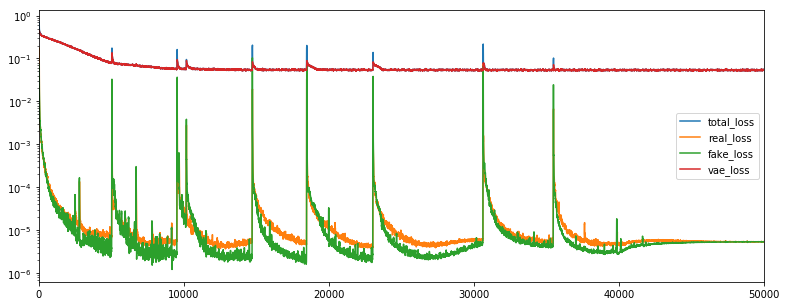

In [14]:
pd.DataFrame(loss_history).rolling(20).mean().plot(logy=True, figsize=(13, 5))

In [15]:
def quick_disp(i):
    t = epoch_samples[i]
    GANTrainer.grid_display(t.reshape(-1, 3, 64, 64), 
                            title='Epoch %d' %i);
    
widgets.interact(quick_disp,
                i=widgets.IntSlider(0, 0, len(epoch_samples)-1));

interactive(children=(IntSlider(value=0, description='i', max=49), Output()), _dom_classes=('widget-interact',…

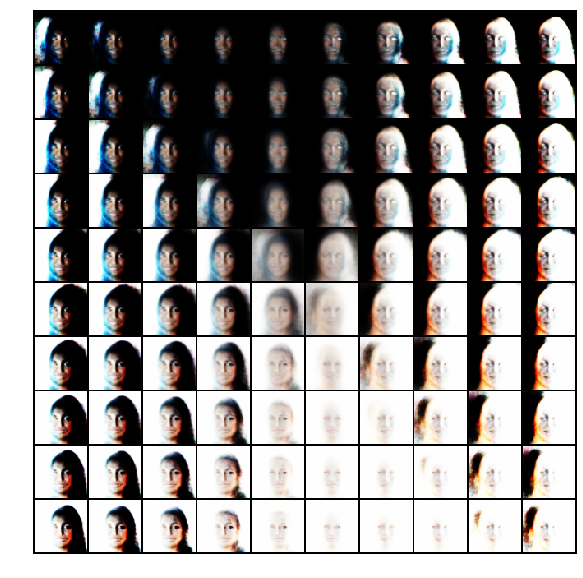

In [18]:
lin_space = (-3, 3, 10)
z_values = torch.tensor([[z0, z1] 
                         for z0 in np.linspace(*lin_space) 
                             for z1 in np.linspace(*lin_space)]).reshape(lin_space[-1]**2,
                                                                     2, 
                                                                     1, 1).float()

latent_grid = model.decoder(z_values.to('cuda').reshape(-1, 2)).reshape(img_shape)

GANTrainer.grid_display(latent_grid, nrow=lin_space[-1]);

In [20]:
img_shape = (-1, 3, 64, 64)

def plot_from_z(z0, z1):
    _z = torch.tensor([[z0, z1]]).reshape(-1, 2).float().to('cuda')
    _z_img = model.decoder(_z).reshape(*img_shape)
    GANTrainer.grid_display(_z_img, 
                                      figsize=(6, 6),
                                     title="z0=%.2f; z1=%.2f" % (z0, z1));
widgets.interact(plot_from_z, 
                 z0=widgets.FloatSlider(0., min=-10, max=10, step=0.01), 
                 z1=widgets.FloatSlider(0., min=-10, max=10, step=0.01))

interactive(children=(FloatSlider(value=0.0, description='z0', max=10.0, min=-10.0, step=0.01), FloatSlider(va…

<function __main__.plot_from_z(z0, z1)>